In [1]:
import os
import pandas as pd
import numpy as np
from os import listdir
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
from scipy import ndimage
import seaborn as sns
import cv2
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score
from PIL import Image
import imgaug.augmenters as iaa
import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.experimental import CosineDecay

In [2]:
from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Preparing the data

In [3]:
#path to the dataset folder
data_folder_path = <PATH_TO_DATA_FOLDER>
#import the csv file
sample_df = pd.read_csv(data_folder_path + "/whole_lung_label.csv")#,low_memory=False)

In [4]:
print("Shape = ",sample_df.shape)
sample_df.head()

Shape =  (4773, 2)


,image_name,whole_lung
0,1.2.826.0.1.3680043.9.3218.1.1.125865.1069.161...,0
1,1.2.826.0.1.3680043.9.3218.1.1.3380340.9472.16...,0
2,1.2.826.0.1.3680043.9.3218.1.1.506673.1446.161...,1
3,1.2.826.0.1.3680043.9.3218.1.1.208148.1489.159...,0
4,1.2.826.0.1.3680043.9.3218.1.1.1579787.1083.15...,0


In [5]:
# Double check if there are any corrupted file path
count_file =0
count_no_such_file = 0
drop_i_row = []

for i in tqdm(range(len(sample_df))):
    jpg_image = data_folder_path + "/" + sample_df.image_name.iloc[i]
    if os.path.exists(jpg_image): 
        count_file = count_file +1
    else:
        drop_i_row.append(i)
        count_no_such_file = count_no_such_file + 1

print(count_file,count_no_such_file)
sample_df = sample_df.drop(drop_i_row) 

100%|██████████| 4773/4773 [00:02<00:00, 2015.81it/s]

4773 0


In [6]:
# Find class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = sample_df.whole_lung.value_counts()
total_number_img = neg + pos
weight_for_0 = (1 / neg) * (total_number_img / 2.0)
weight_for_1 = (1 / pos) * (total_number_img / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.69
Weight for class 1: 1.85


In [7]:
# Train-test split
X = data_folder_path + "/" + sample_df.image_name
y = sample_df.whole_lung
X_train, X_sub, y_train, y_sub = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_sub, y_sub, test_size=0.50, random_state=42)
print('Number of images in the train set: ',len(X_train))
print('Number of images in the validation set: ',len(X_val))
print('Number of images in the test set: ',len(X_test))

Number of images in the train set:  3341
Number of images in the validation set:  716
Number of images in the test set:  716


## Examples for the classification task

Whole lung:


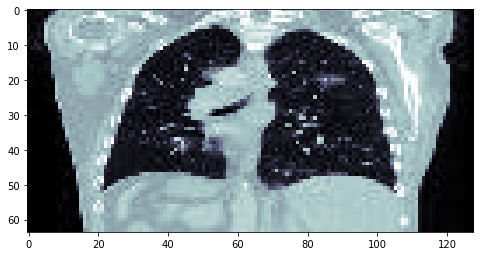

Not contain whole lung:


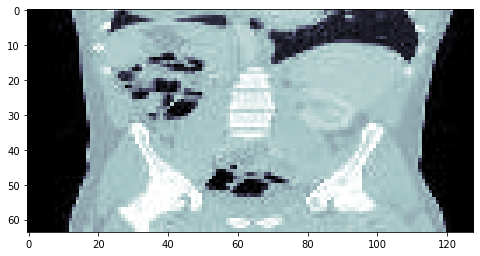

In [8]:
# Examples of whole lung vs others. Coronal slice in current path.
image_path = data_folder_path + "/" + sample_df.image_name.iloc[2]
image = cv2.imread(image_path,0)
image_R = ndimage.rotate(image, 180, reshape=False)
print("Whole lung:")
plt.figure(figsize=(8,8))
plt.imshow(image_R,cmap=plt.cm.bone)
plt.show()

image_path = data_folder_path + "/" + sample_df.image_name.iloc[1650]
image = cv2.imread(image_path,0)
image_R = ndimage.rotate(image, 180, reshape=False)
print("Not contain whole lung:")
plt.figure(figsize=(8,8))
plt.imshow(image_R,cmap=plt.cm.bone)
plt.show()

## Preparing the model

In [9]:
#input the parameters for the model training
batch_size = 64 #8
image_size_h = 64 #64
image_size_w = 128 #128
dropout_rate = 0.2 #0.3
aug_rotation = (-0.05,0.05) #(-0.05,0.05)
aug_zoom = (-0.2, 0) #(-0.2, 0)
aug_contrast = (0.2,0.2) #(0.2,0.2)
aug_coarsedropout = (0.0, 0.10) # (0.0, 0.10)
aug_invert = 0.5 # 0.5

set_model_tag = "ENB1"
set_model_path = "model_whole_lung_classifier/"
epochs = 8

initial_learning_rate=1e-4 #1e-4
alpha=0.3 # 0.3

input_shape = (image_size_h, image_size_w, 3)

In [10]:
# define the classes and get number of classes
classes_to_predict = sorted(sample_df.whole_lung.unique())
num_classes = len(classes_to_predict)

In [11]:
#Image augmentations (keras)
data_augmentation_layers = tf.keras.Sequential([
#                     layers.experimental.preprocessing.RandomCrop(height=image_size, width=image_size),
#                     layers.experimental.preprocessing.RandomFlip("horizontal"),
                    layers.experimental.preprocessing.RandomRotation(aug_rotation, fill_mode="constant"),
                    layers.experimental.preprocessing.RandomZoom(aug_zoom, fill_mode="constant"),
                    layers.experimental.preprocessing.RandomContrast(aug_contrast)                
                    ])

#Image augmentations (imgaug)
seq = iaa.Sequential([
                    iaa.CoarseDropout(aug_coarsedropout),
                    iaa.Invert(aug_invert)
                    ])

In [12]:
#define the function to load the image and label from the path
def load_image_and_label_from_path(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img, label

def augment_batch(image, label):
    def augment_image(image):
        return seq.augment(image=image.numpy())

    image = tf.cast(image, tf.uint8)
    image = tf.py_function(augment_image, [image], tf.uint8)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
# Define function to build the model (EfficientNetB1)
from tensorflow.keras.applications import EfficientNetB1

def create_model():
    enb1 = EfficientNetB1(weights='imagenet', 
                          include_top=False, 
                          input_shape=input_shape, 
                          drop_connect_rate=dropout_rate
                          )

    inputs = Input(shape=input_shape)
    augmented = data_augmentation_layers(inputs)
    enb1 = enb1(augmented)
    pooling = layers.GlobalAveragePooling2D()(enb1)
    dropout = layers.Dropout(dropout_rate)(pooling)
    outputs = Dense(num_classes, activation="softmax")(dropout)
    model_enb1 = Model(inputs=inputs, outputs=outputs)
    return model_enb1

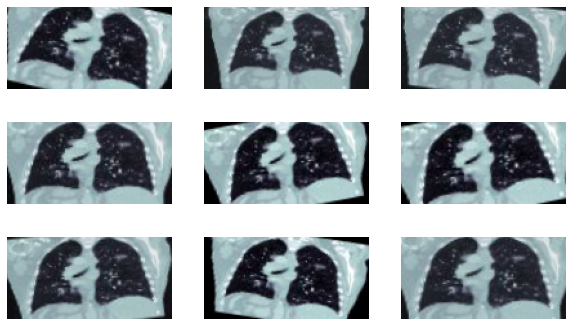

In [14]:
image_path = data_folder_path + "/" + sample_df.image_name.iloc[2]
image = Image.open(image_path)
image = ndimage.rotate(image, 180, reshape=False)
image = tf.expand_dims(np.array(image), 0)
plt.figure(figsize=(10, 6))
for i in range(9):
    augmented_image = data_augmentation_layers(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

In [15]:
# create list for model training
TEST_ACCURACY = []
TEST_LOSS = []
HISTORY_HISTORY_ACCURACY = []
HISTORY_HISTORY_VALACCURACY = []
HISTORY_HISTORY_LOSS = []
HISTORY_HISTORY_VALLOSS = []

In [16]:
# path and name for the model weight to save 
this_model_path = set_model_path+"model_whole_lung_demo.h5"

In [17]:
#build the dataset
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
training_data = training_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
validation_data = validation_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)
test_data = test_data.map(load_image_and_label_from_path, num_parallel_calls=AUTOTUNE)

In [18]:
training_data = training_data.map(augment_batch)
#create the batches
training_data_batches = training_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
validation_data_batches = validation_data.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_data_batches = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

## Build the model and train the model

In [19]:
#import the model
model = create_model()
epochs = epochs
decay_steps = int(round(len(X_train)/batch_size))*epochs
cosine_decay = CosineDecay(initial_learning_rate=initial_learning_rate, decay_steps=decay_steps, alpha=alpha)
callbacks = [ModelCheckpoint(filepath=this_model_path, monitor='val_loss', save_best_only=True)]
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 128, 3)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 64, 128, 3)        0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 2, 4, 1280)        6575239   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 6,577,801
Trainable params: 6,515,746
Non-trainable params: 62,055
_______________________________________

In [20]:
history = model.fit(training_data_batches,
                        epochs = epochs, 
                        validation_data=validation_data_batches,
                        class_weight=class_weight,
                        callbacks=callbacks)

HISTORY_HISTORY_ACCURACY.append(history.history['accuracy'])
HISTORY_HISTORY_VALACCURACY.append(history.history['val_accuracy'])
HISTORY_HISTORY_LOSS.append(history.history['loss'])
HISTORY_HISTORY_VALLOSS.append(history.history['val_loss'])

Epoch 1/8
53/53 [==============================] - 11s 213ms/step - loss: 0.3801 - accuracy: 0.7953 - val_loss: 0.2685 - val_accuracy: 0.9190
Epoch 2/8
53/53 [==============================] - 9s 171ms/step - loss: 0.1650 - accuracy: 0.9368 - val_loss: 0.2210 - val_accuracy: 0.9427
Epoch 3/8
53/53 [==============================] - 9s 173ms/step - loss: 0.1325 - accuracy: 0.9533 - val_loss: 0.1713 - val_accuracy: 0.9623
Epoch 4/8
53/53 [==============================] - 9s 172ms/step - loss: 0.0971 - accuracy: 0.9644 - val_loss: 0.1236 - val_accuracy: 0.9735
Epoch 5/8
53/53 [==============================] - 9s 173ms/step - loss: 0.0847 - accuracy: 0.9725 - val_loss: 0.0925 - val_accuracy: 0.9804
Epoch 6/8
53/53 [==============================] - 9s 173ms/step - loss: 0.0814 - accuracy: 0.9704 - val_loss: 0.0774 - val_accuracy: 0.9818
Epoch 7/8
53/53 [==============================] - 9s 173ms/step - loss: 0.0757 - accuracy: 0.9752 - val_loss: 0.0673 - val_accuracy: 0.9846
Epoch 8/8
53

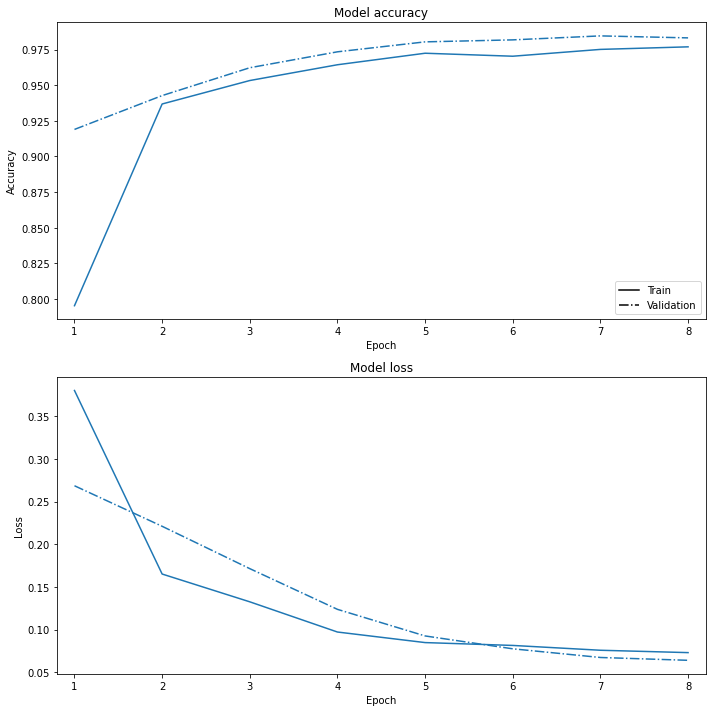

In [21]:
def plot_learning_curve(HISTORY_HISTORY_ACCURACY,HISTORY_HISTORY_VALACCURACY,HISTORY_HISTORY_LOSS,HISTORY_HISTORY_VALLOSS):
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot([-1,-1],[max(max(HISTORY_HISTORY_ACCURACY)),max(max(HISTORY_HISTORY_ACCURACY))],color="black",linestyle="-")
    plt.plot([-1,-1],[max(max(HISTORY_HISTORY_ACCURACY)),max(max(HISTORY_HISTORY_ACCURACY))],color="black",linestyle="-.")
    plt.legend(['Train','Validation'], loc='lower right')
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_ACCURACY).T)
    plt.gca().set_prop_cycle(None)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_VALACCURACY).T,"-.")
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.xlim([0.8, epochs+0.2])
    #plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(2,1,2)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_LOSS).T)
    plt.gca().set_prop_cycle(None)
    plt.plot(range(1,epochs+1),np.array(HISTORY_HISTORY_VALLOSS).T,"-.")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xlim([0.8, epochs+0.2])
    plt.tight_layout()
    #plt.savefig('./loss_curve.png')
    
plot_learning_curve(HISTORY_HISTORY_ACCURACY,HISTORY_HISTORY_VALACCURACY,HISTORY_HISTORY_LOSS,HISTORY_HISTORY_VALLOSS)

## Quick testing on the model performance

In [22]:
# LOAD MODEL to evaluate the performance of the model
model.load_weights(this_model_path)

print("Evaluate")
results = model.evaluate(test_data_batches)
results = dict(zip(model.metrics_names,results))

TEST_ACCURACY.append(results['accuracy'])
TEST_LOSS.append(results['loss'])

#tf.keras.backend.clear_session()
print("Test accuracy = ",results['accuracy'])
print("Test loss = ",results['loss'])

Evaluate
12/12 [==============================] - 0s 26ms/step - loss: 0.0761 - accuracy: 0.9777
Test accuracy =  0.9776536226272583
Test loss =  0.07607999444007874


In [23]:
# define useful function for the performamce analysis

# set plots font
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

def predict_image(filepath):
    """
    This function give prediction on one image
    """
    img = np.array([np.array(Image.open(filepath))])
    result = model.predict(img)
    return np.argmax(result)

def test_image(idx):
    """
    This function do prediction test on one image
    """
    result = predict_image(X_test.iloc[idx])
    expected_output = y_test.iloc[idx]
    image_name = os.path.basename(X_test.iloc[idx])
    print("Image:{}".format(image_name))
    print("expected output: {}".format(expected_output))
    print("predicted output:{}".format(result))
    print("-----------------------------------")
    return

def pick_up_right_prediction(idx):
    """
    This function pick up any right prediction through the image index (idx)
    """
    result = predict_image(X_test.iloc[idx])
    expected_output = y_test.iloc[idx]
    image_name = os.path.basename(X_test.iloc[idx])
    if result == expected_output:
        print("Image:{}".format(image_name))
        if expected_output == 0:
            print("expected output:  Others     = {}".format(expected_output))
        else:
            print("expected output:  Whole lung = {}".format(expected_output))
        if result == 0:
            print("predicted output: Others     = {}".format(result))
        else:
            print("predicted output: Whole lung = {}".format(result))
        image = cv2.imread(X_test.iloc[idx],0)
        image_R = ndimage.rotate(image, 180, reshape=False)
        plt.figure(figsize=(8,8))
        plt.imshow(image_R,cmap=plt.cm.bone)
        plt.show()
        print("---------------------------------------------")
    else:
        pass
    return (result == expected_output)

def pick_up_wrong_prediction(idx):
    """
    This function pick up any wrong prediction through the image index (idx)
    """
    result = predict_image(X_test.iloc[idx])
    expected_output = y_test.iloc[idx]
    image_name = os.path.basename(X_test.iloc[idx])
    if result == expected_output:
        pass
    else:
        print("Image:{}".format(image_name))
        if expected_output == 0:
            print("expected output:  Others     = {}".format(expected_output))
        else:
            print("expected output:  Whole lung = {}".format(expected_output))
        if result == 0:
            print("predicted output: Others     = {}".format(result))
        else:
            print("predicted output: Whole lung = {}".format(result))
        image = cv2.imread(X_test.iloc[idx],0)
        image_R = ndimage.rotate(image, 180, reshape=False)
        plt.figure(figsize=(8,8))
        plt.imshow(image_R,cmap=plt.cm.bone)
        plt.show()
        print("---------------------------------------------")
    return (result == expected_output)
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(true_classes, test_predictions):
    """This function plot the ROC curve and give the AUC-ROC score"""
    pred_classes_ravel = test_predictions[:,1].ravel()
    fpr, tpr, thresholds = roc_curve(true_classes, pred_classes_ravel)
    plt.figure(figsize=(7,7))
    plt.plot(fpr, tpr, 'b',linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=1.5, color='k')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(['ROC curve', 'Trivial model (AUC 0.5)'],loc='lower right')
    # get the AUC-ROC score from the prediction probabilities
    AUC_ROC_SCORE = roc_auc_score(true_classes,pred_classes_ravel,average='weighted')
    print("AUC-ROC score = ",AUC_ROC_SCORE)
    return

## Model performance analysis

In [24]:
# Classification on the test set
test_data_batches = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_predictions = model.predict(test_data_batches)
# Get most likely class
predicted_classes = np.argmax(test_predictions, axis=1)

#Get ground-truth classes and class-labels
true_classes = np.concatenate([y for x, y in test_data_batches], axis=0)
class_labels = ['Others','WholeLung'] # label 0 = Others; 1 = WholeLung

              precision    recall  f1-score   support

      Others       0.99      0.98      0.98       522
   WholeLung       0.94      0.97      0.96       194

    accuracy                           0.98       716
   macro avg       0.97      0.98      0.97       716
weighted avg       0.98      0.98      0.98       716

AUC-ROC score =  0.9956155942647233


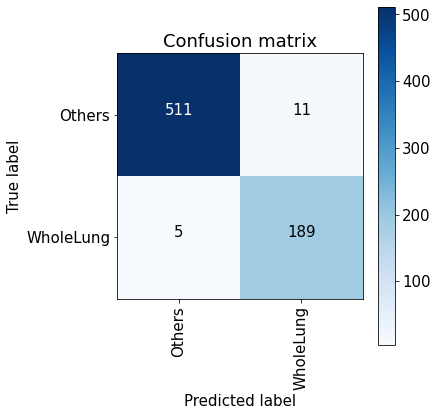

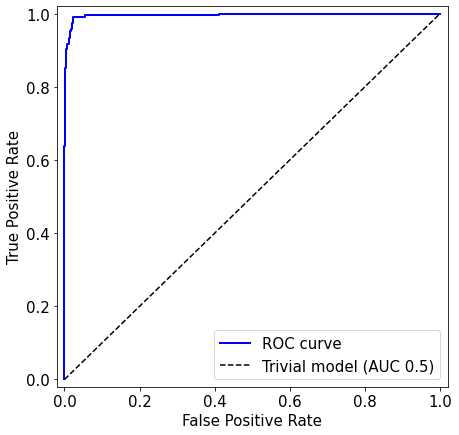

In [25]:
# Analysis on the classification performance on the test set
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

#plot confusion matrix
cm = confusion_matrix(true_classes,predicted_classes)
plot_confusion_matrix(cm, class_labels, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues)

#plot the ROC curve
plot_roc_curve(true_classes, test_predictions)

## Model performance on individual examples

In [26]:
for x in random.sample(range(0, len(test_data)), 5): # test the prediction on 5 random images
    test_image(x)

Image:1.2.826.0.1.3680043.9.3218.1.1.365443.2956.1619056439474.32650.0.jpg
expected output: 0
predicted output:0
-----------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.125865.1069.1616460161570.38492.0.jpg
expected output: 0
predicted output:0
-----------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.310315491.1430.1597108879933.18.0.jpg
expected output: 1
predicted output:1
-----------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.365443.2956.1618648339001.17828.0.jpg
expected output: 1
predicted output:1
-----------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.137636.1535.1624915219781.17632.0.jpg
expected output: 0
predicted output:0
-----------------------------------


Image:1.2.826.0.1.3680043.9.3218.1.1.137636.1535.1624874034399.15167.0.jpg
expected output:  Others     = 0
predicted output: Others     = 0


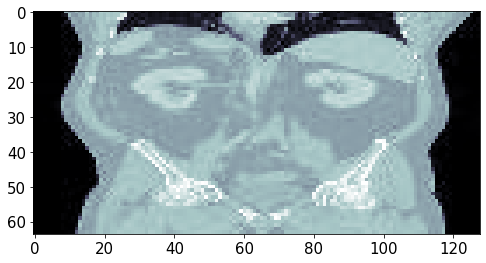

---------------------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.125865.1069.1616166387465.44339.0.jpg
expected output:  Others     = 0
predicted output: Others     = 0


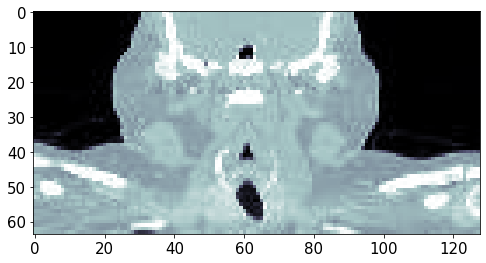

---------------------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.157978.1083.1599796265308.53468.0.jpg
expected output:  Whole lung = 1
predicted output: Whole lung = 1


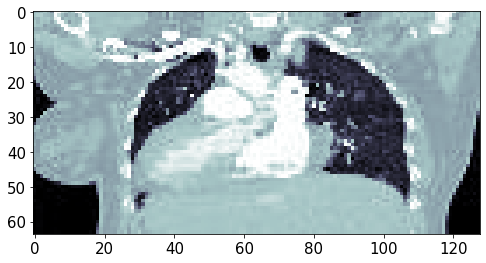

---------------------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.197076.2038.1598072572138.22006.0.jpg
expected output:  Whole lung = 1
predicted output: Whole lung = 1


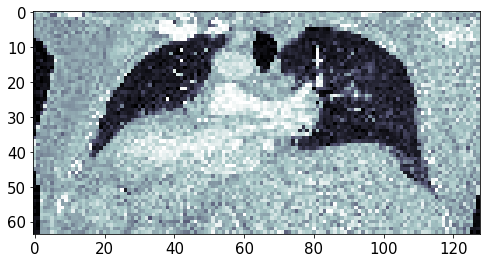

---------------------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.260137.1749.1596330236241.36951.0.jpg
expected output:  Others     = 0
predicted output: Others     = 0


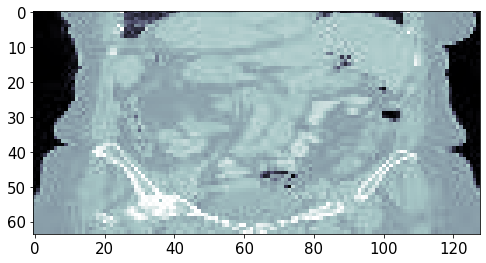

---------------------------------------------


In [27]:
# show few examples that the model predictions are right
right_count = 0
for x in random.sample(range(0, len(test_data)), len(test_data)):
    if right_count < 5:
        outcome = pick_up_right_prediction(x)
        if outcome == True:
            right_count += 1

Image:1.2.826.0.1.3680043.9.3218.1.1.208148.1489.1595707979258.35128.0.jpg
expected output:  Others     = 0
predicted output: Whole lung = 1


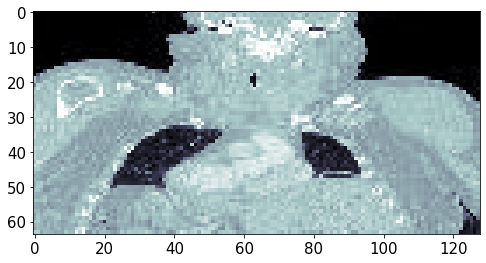

---------------------------------------------
Image:1.2.826.0.1.3680043.9.3218.1.1.263688.1492.1617544617714.22008.0.jpg
expected output:  Others     = 0
predicted output: Whole lung = 1


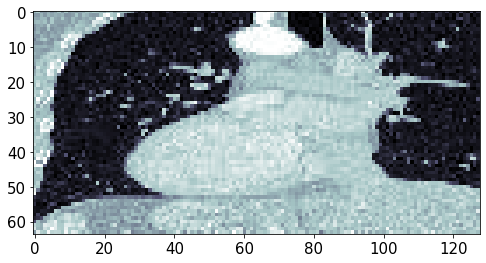

---------------------------------------------


In [28]:
# show few examples that the model predictions are wrong
wrong_count = 0
for x in random.sample(range(0, len(test_data)), len(test_data)):
    if wrong_count < 2:
        outcome = pick_up_wrong_prediction(x)
        if outcome == False:
            wrong_count += 1